### <span style='color:Blue'> Spread Out Bragg Peak  </span>
    - Calculate Energy for each depth
    - Determine weighting factor using least square
    - Draw Bragg peak 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import math as mt
import ROOT
import os
import random
from array import array
#import rootplot.root2matplotlib as r2m
from MyFunction import *
from ROOT import TCanvas, gStyle, TFile, TProfile, TNtuple, TH1D, TH2D, TH3D, TGraph, TMultiGraph, TPad, THStack, TH1F, TLegend, gROOT 

### <span style='color:Blue'> Range-Energy relation   </span>
\begin{equation*}
    R = \alpha E_{0}^p \\ 
    E_{0} = \Bigl(\frac{R}{\alpha}\Bigr)^\frac{1}{p}\\
    \alpha = 1.9 * 10^{-3} \\
    p = 1.8
\end{equation*}

### <span style='color:Blue'> Calculate beam energies for SOBP  </span>

In [25]:
startPeak = 12
endPeak   = 18
numberBeam = 13
energyList = BraggPeakEnergyList(startPeak, endPeak, numberBeam)
Energy_List_DF = pd.DataFrame(energyList)
print(Energy_List_DF)

             0
0   129.225640
1   132.189819
2   135.101750
3   137.964312
4   140.780127
5   143.551588
6   146.280888
7   148.970043
8   151.620911
9   154.235208
10  156.814526
11  159.360340
12  161.874026


### <span style='color:Blue'> List of data files to produce SOBP   </span>

In [14]:
DataFileLocation = "/home/fardousr/Desktop/Output/Bragg Peak DataFile"
DataFileList = os.listdir(DataFileLocation)
Files = pd.DataFrame(DataFileList)
print(Files)

                                                    0
0   Coll_Energy_129_Alpha:_0.0_Beta:_18800mm_Radiu...
1   Coll_Energy_132_Alpha:_0.0_Beta:_18800mm_Radiu...
2   Coll_Energy_135_Alpha:_0.0_Beta:_18800mm_Radiu...
3   Coll_Energy_137_Alpha:_0.0_Beta:_18800mm_Radiu...
4   Coll_Energy_140_Alpha:_0.0_Beta:_18800mm_Radiu...
5   Coll_Energy_143_Alpha:_0.0_Beta:_18800mm_Radiu...
6   Coll_Energy_146_Alpha:_0.0_Beta:_18800mm_Radiu...
7   Coll_Energy_148_Alpha:_0.0_Beta:_18800mm_Radiu...
8   Coll_Energy_151_Alpha:_0.0_Beta:_18800mm_Radiu...
9   Coll_Energy_154_Alpha:_0.0_Beta:_18800mm_Radiu...
10  Coll_Energy_156_Alpha:_0.0_Beta:_18800mm_Radiu...
11  Coll_Energy_159_Alpha:_0.0_Beta:_18800mm_Radiu...
12  Coll_Energy_161_Alpha:_0.0_Beta:_18800mm_Radiu...


### <span style='color:Blue'> Plot Bragg Peak for all energies   </span>

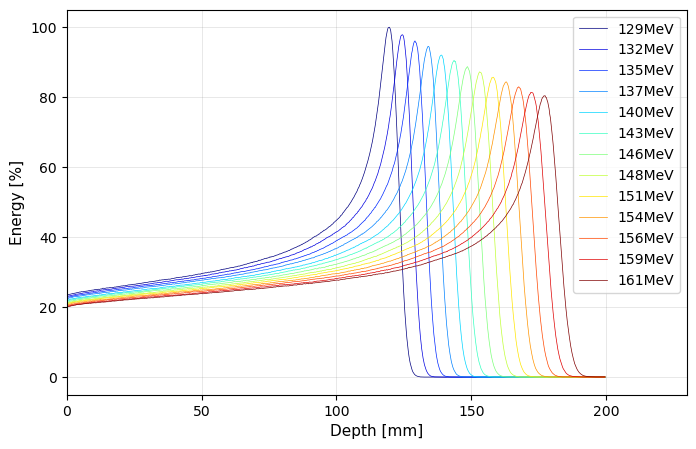

In [16]:
from pylab import rcParams
plt.rcdefaults()
rcParams['figure.figsize'] = 8, 5
plt.rcParams['axes.facecolor'] = 'white'

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(DataFileList)))))


for j in range(len(DataFileList)): 
    numBins  = Energy_Z.GetNbinsX()
    maxX     = Energy_Z.GetXaxis().GetXmax()
    binwidth = Energy_Z.GetBinWidth(0)
    DataFile = ROOT.TFile(DataFileLocation+"/"+DataFileList[j])
    Energy_Z = DataFile.Get('ProtonEnergyHisto')
    Energy   = array( 'd' )
    depth    = array( 'd' )
    if(j==0):
        maxbinNum   = Energy_Z.GetMaximumBin()
        #maxbinValue = Energy_Z.GetXaxis().GetBinCenter(maxbinNum);
        maxbinValue = Energy_Z.GetBinContent(maxbinNum);

    for i in range(1, numBins):
        depth.append(Energy_Z.GetXaxis().GetBinCenter(i))#(binwidth*(i-1))+(binwidth/2))
        Energy.append(Energy_Z.GetBinContent(i)*100/maxbinValue)
        lineLegend = DataFileList[j][12:15]+"MeV"
    plt.plot(depth, Energy, label = lineLegend, linewidth=.5)
    plt.xlim(0, 230)
    plt.grid(alpha =0.25, axis='both' , color='gray', linestyle='-', linewidth=.5)
    plt.legend(loc='upper right')
    plt.xlabel("Depth [mm]", fontsize=11)
    plt.ylabel("Energy [%]", fontsize=11)
plt.savefig("BraggPeak.png", dpi = 400)
plt.show()

### <span style='color:Blue'> Data accumulation for weighting factors calculation  </span>

In [9]:
SOBP_Energy = []

DataFile = ROOT.TFile(DataFileLocation+"/"+DataFileList[0])
Energy_Z = DataFile.Get('ProtonEnergyHisto')
SOBP_Start_Bin   = Energy_Z.GetMaximumBin()

DataFile = ROOT.TFile(DataFileLocation+"/"+DataFileList[len(DataFileList)-1])
Energy_Z = DataFile.Get('ProtonEnergyHisto')
SOBP_End_Bin   = Energy_Z.GetMaximumBin()

for j in range(0, len(DataFileList)):
    DataFile = ROOT.TFile(DataFileLocation+"/"+DataFileList[j])
    Energy_Z = DataFile.Get('ProtonEnergyHisto')
    Energy   = array( 'd' )
    depth    = array( 'd' )
    
    for i in range(SOBP_Start_Bin, SOBP_End_Bin):
        Energy.append(Energy_Z.GetBinContent(i))

    SOBP_Energy.append(Energy)

### <span style='color:Blue'> Estimate weighting factors using LS(scipy nnls)  </span>

In [18]:
numberofBins = SOBP_End_Bin - SOBP_Start_Bin
SOBPConstantDose = np.full((np.shape(SOBP_Energy)[1], 1), max(SOBP_Energy[0])*20, dtype=float)
# print(SOBPConstantDose)

from scipy.optimize import nnls
Coefficient = np.transpose(SOBP_Energy)
dependent   = SOBPConstantDose[:,0]
w, q = nnls(Coefficient, dependent)
print(pd.DataFrame(w))

            0
0    1.747376
1    1.434767
2    1.743745
3    1.745657
4    1.971522
5    2.148097
6    2.514480
7    2.606022
8    3.365967
9    3.214440
10   5.745217
11   2.451250
12  22.379313


### <span style='color:Blue'> Produce SOBP with constituent graphs  </span>

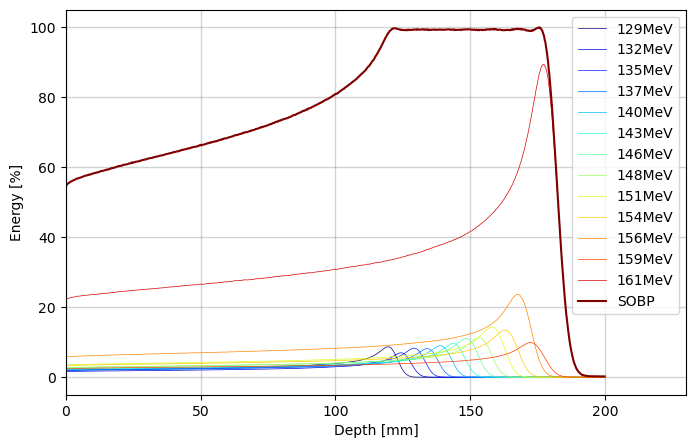

In [21]:
SOBPTotalDose = np.full((numBins), 0.0, dtype=float)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, len(DataFileList)+1))))

#p=1
for j in range(len(DataFileList)): 
    numBins  = Energy_Z.GetNbinsX()
    maxX     = Energy_Z.GetXaxis().GetXmax()
    binwidth = Energy_Z.GetBinWidth(0)
    DataFile = ROOT.TFile(DataFileLocation+"/"+DataFileList[j])
    Energy_Z = DataFile.Get('ProtonEnergyHisto')
    Energy   = array( 'd' )
    depth    = array( 'd' )

    for i in range(1, numBins+1):
        depth.append(Energy_Z.GetXaxis().GetBinCenter(i))
        Energy.append(Energy_Z.GetBinContent(i))
        w_Energy = np.array(Energy)*w[j]
    lineLegend = DataFileList[j][12:15]+"MeV"
    plt.plot(depth, w_Energy*100/p, label = lineLegend, linewidth=.5)
    SOBPTotalDose = SOBPTotalDose + w_Energy
plt.plot(depth, SOBPTotalDose*100/p, label ="SOBP", linewidth=1.5)
p=max(SOBPTotalDose)
plt.xlim(0, 230)
plt.grid(alpha =0.35, axis='both' , color='gray', linestyle='-', linewidth=1)
plt.legend(loc='upper right')
plt.xlabel("Depth [mm]")
plt.ylabel("Energy [%]")

plt.savefig("SpreadOutBraggPeak.png", dpi = 400)
plt.show()

### <span style='color:Blue'> Produce SOBP graph  </span>

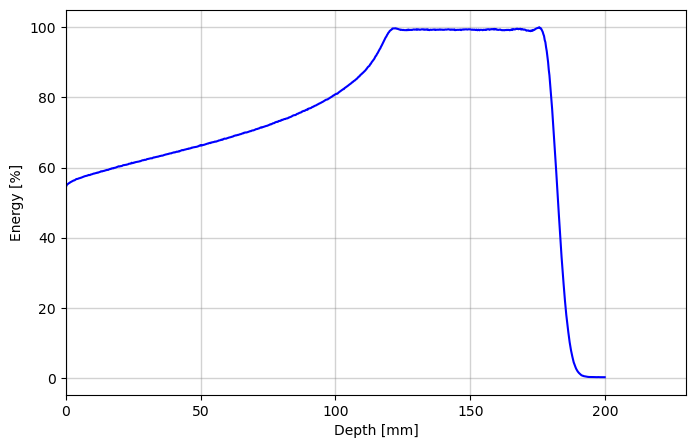

In [202]:
plt.plot(depth, SOBPTotalDose*100/max(SOBPTotalDose), '-b')
# plt.fill_between(depth, SOBPTotalDose)
plt.xlim(0, 230)
plt.grid(alpha =0.35, axis='both' , color='gray', linestyle='-', linewidth=1)
plt.xlabel("Depth [mm]")
plt.ylabel("Energy [%]")
plt.show()